# Predicting Airbnb Revenue on 2019 Host Listings and Exploring the Impact of COVID-19 on 2020 Listing Prices in New York City
#### Team 3B (Yulong Gong, Peter Mankiewich, Ruchika Venkateswaran, Yi-shuan Wang, Yangyang Zhou)

---

## Project Objectives
Our primary objectives are:
* Analyzing neighborhood popularity for superhosts and non superhosts, based on traffic, types of rooms (Private Rooms/Shared Rooms/Entire Apartment), and price
* Drawing a comparison between the pre- and post-COVID listing prices
* Predicting the type of host (superhosts/non-superhosts) and understanding what attributes contribute to the classification of a superhost
* Predicting the price for Airbnb listings in New York City and understanding what features contribute to profitable business opportunities for Airbnb



## Dataset Overview
Our data has been taken from 4 files as listed below. The datasets have been taken from [InsideAirbnb](http://insideairbnb.com/get-the-data.html) and were last updated in October 2020.


1. [Listings](http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/listings.csv.gz) (Detailed listings data for New York City.)
2. [Reviews](http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/reviews.csv.gz) (Detailed review data for listings in New York City.)
3. [Calendar](https://data.insideairbnb.com/united-states/ny/new-york-city/2020-01-03/data/calendar.csv.gz)(Detailed calendar data for listings in New York City.)
4. [Neighborhoods](http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/visualisations/neighbourhoods.csv) (Neighbourhood list for geo filter. Sourced from city or open source GIS files.)



# Import Required Packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
! pip install missingno
import missingno as msno
import math
from os import path

# plotly imports
! pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

! pip install wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# folium imports
! pip install folium
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

#importing models for preprocessing and splitting data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#importing packages for classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from IPython.display import Image

# Reading in Data

In [ ]:
listings = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/listings.csv.gz")
calendar_2020_1 = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2020-01-03/data/calendar.csv.gz")
reviews = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/data/reviews.csv.gz", parse_dates=['date'])
neighborhoods = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2020-10-05/visualisations/neighbourhoods.csv")

# Inspecting the Dataset

## Listings DataFrame


**Here is a glimpse of the Listings dataframe.**

In [ ]:
listings.head(1)

**How many observations and features are in the Listings dataframe?**

There are 44666 unique observations (listing ids) and 74 features.

In [ ]:
print(listings.shape)
print(len(listings.id.unique()))

**Here is an overview of the Listings dataframe.**

In [ ]:
listings.info()

## Calendar DataFrame

**Here is a glimpse of the calendar_2020_1 dataframe.**

In [ ]:
calendar_2020_1.head(2)

**How many observations and features are there?**

There are 18747307 observations and 7 features.



In [ ]:
calendar_2020_1.shape

**Here is an overview of the dataframe.**

In [ ]:
calendar_2020_1.info()

**Summary statistics for the numeric columns (Price will be converted from an object later in the notebook):**



In [ ]:
calendar_2020_1[['minimum_nights','maximum_nights']].describe()

## Reviews DataFrame

**Here is a glimpse of the Reviews dataframe.**

In [ ]:
reviews.head(2)

**How many observations and features are in the Reviews dataframe?**

There are 1003064 unique observations (comments) and 6 features.

In [ ]:
print(reviews.shape)
print(len(reviews.id.unique()))

**Here is an overview of the Reviews dataframe.**

In [ ]:
reviews.info()

## Neighborhoods DataFrame

**Here is a glimpse of the Neighborhoods dataframe.**

In [ ]:
neighborhoods.head(2)

**How many observations and features are in the Neighborhoods dataframe?**

There are 230 unique observations (neighborhoods) and 2 features.

In [ ]:
print(neighborhoods.shape)
print(len(neighborhoods.neighbourhood.unique()))

**Here is an overview of the Neighborhoods dataframe.**

In [ ]:
neighborhoods.info()

**Summary statistics for the Neighborhoods dataframe:**

In [ ]:
neighborhoods.describe()

**How many neighborhoods are there in each borough?**

Queens has the most neighborhoods (53) and Manhattan has the least (32).

In [ ]:
neighborhoods.groupby('neighbourhood_group').count()

**A preview of the neighborhoods within a borough:**

In [ ]:
# Take Manhattan for example
neighborhoods[neighborhoods['neighbourhood_group'] == "Manhattan"].head()

# Cleaning the Dataset

## Listings DataFrame

After inspecting the Listings dataframe, we now proceed to analyze potential misssing values and outliers. We will also ensure that data within each of the columns is of the right datatype and format, and is ready to be used in the rest of the EDA phase.

**How many missing values are there in each column?**

There are three empty columns -- "bathrooms", "calendar_updated", and "license".

In [ ]:
null_vals = listings.isnull().sum()
null_vals[null_vals > 0].sort_values(ascending=False)

**Converting "price" column to the correct format and data type.**

In [ ]:
# First converting price into a string to remove '$' and ',' and then converting it into a float 
listings['price'] = listings['price'].astype('string')
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].astype('float')
listings['price']

**How many listings are with a price of $0?**

There are 25 observations (listings) where the price is $0.

In [ ]:
# Identifying rows with price of the listing as $0
listings[listings['price'] == 0]['price'].count()

**How many listings have no beds?**

There are 1595 listings with no beds, which equals to 3.57% of the total number of listings.

In [ ]:
# Identifying rows with no beds
listings[listings['beds'] == 0]['beds'].count() / len(listings)

**Which listing has the most beds?**

We learned from the summary statistics that the maximum number of beds is 40 among all listings. After inspecting this outlier, we found that this observation is reasonable and should not be dropped from the dataframe since it says it hosts 16 people.

In [ ]:
# Inspecting rows with 40 beds
listings[listings['beds'] == 40]

We will drop all observations in which the price, number of beds, or accommodates is zero since these values would not make sense in context.

In [ ]:
drop_df = listings[(listings['beds'] == 0) | (listings['price'] == 0) | (listings['accommodates'] == 0)].index
listings.drop(drop_df, inplace=True)

After finding that the median number of beds and bedrooms is 1, we have filled the missing values for both these columns with 1.

In [ ]:
listings['beds'].median()

In [ ]:
listings['bedrooms'].median()

In [ ]:
listings.beds = listings.beds.fillna(1)

In [ ]:
listings.bedrooms = listings.bedrooms.fillna(1)

We will also remove observations with missing values in any of these columns.

In [ ]:
listings.dropna(subset=['first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month'], thresh=10, inplace=True)

Lastly, we decide to drop the columns that are not significant to EDA and furthur analysis.

In [ ]:
listings.drop(['scrape_id', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'bathrooms','calendar_updated','license', 'host_total_listings_count', 'calendar_last_scraped'], axis=1, inplace=True)

After cleaning the Listings dataframe, we now have 31880 unique observations (listings) and 60 features.

In [ ]:
listings.shape

### Looking into Host-Related Data

**Are there any missing values within host-related data?**

In [ ]:
msno.matrix(listings[['host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms']])

Image(filename='../plt_14.png') 

**Converting columns to the correct data type.**

In [ ]:
listings.calculated_host_listings_count_shared_rooms = listings.calculated_host_listings_count_shared_rooms.astype('float')
listings.calculated_host_listings_count_private_rooms = listings.calculated_host_listings_count_private_rooms.astype('float')
listings.calculated_host_listings_count_entire_homes = listings.calculated_host_listings_count_entire_homes.astype('float')
listings.calculated_host_listings_count = listings.calculated_host_listings_count.astype('float')

After adding up the count of all room types, the total does not exceed the calculated_host_listings_count.

In [ ]:
check_condition = (listings['calculated_host_listings_count_private_rooms'] + listings['calculated_host_listings_count_entire_homes'] + listings['calculated_host_listings_count_shared_rooms']) > listings['calculated_host_listings_count']
listings[check_condition]

**Examine the distribution of the host acceptance rate.**

In [ ]:
listings['host_acceptance_rate'].value_counts().head()

**Converting columns to the correct format and data type.**

In [ ]:
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].astype("string")
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.replace('%','')
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'], errors='coerce')
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].apply(lambda x: x/100 if isinstance(x, float) else None)

**How many null values are there?**

There are 10147 null values in host_acceptance_rate because Airbnb did not report this for sellers with less reviews and data. We're not imputing the null values at this point because we won't be using this feature for our models.

In [ ]:
listings['host_acceptance_rate'].isnull().sum()

**Examine the distribution of the host reponse rate.**

In [ ]:
listings['host_response_rate'].value_counts().head()

**Converting the columns to the correct format and data types.**

In [ ]:
listings['host_response_rate'] = listings['host_response_rate'].astype("string")
listings['host_response_rate'] = listings['host_response_rate'].str.replace('%','')
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'], errors='coerce')
listings['host_response_rate'] = listings['host_response_rate'].apply(lambda x: x/100 if isinstance(x, float) else None)
listings['host_response_time'] = listings['host_response_time'].astype('string')
listings['host_is_superhost'] = listings['host_is_superhost'].astype('string')

**Examine the distribution of host_response_time.**

In [ ]:
listings['host_response_time'].value_counts().reset_index()

**What is the average response rate for each response time category?**

Hosts who response within an hour have a 97.7% response rate on average.

In [ ]:
listings.groupby('host_response_time')['host_response_rate'].mean()

**What is the relationship between response rate and response time?**

Below is a visualization of the relationship between them. We found that hosts who usually reponse within an hour have the highest response rate on average, while hosts who tend to response after a few days or more have the lowest response rate.

In [ ]:
sns.catplot(x='host_response_time', y='host_response_rate', data=listings, kind='bar', order=['within an hour', 'within a few hours', 'within a day', 'a few days or more'])
plt.xticks(rotation =45)
plt.show();

**Is there is a relationship between acceptance rate and response rate?**

Below is a visualization of host acceptance rate and response rate and there doesn't seem to be an obvious relationship. It is possible that a popular host only respond to messages sent by the few guests he/she accepts and not responding to those he/she does not want to accept, or that a host is constantly declining requests via messages.

In [ ]:
sns.relplot(x='host_response_rate', y='host_acceptance_rate', data=listings, kind='scatter')
plt.show();

**Encoding "host_is_superhost" and "host_identity_verified" values "T" and "F" to 1 and 0 respectively and creating separate column for binary variables.**

In [ ]:
listings.info()

In [ ]:
key = {'t' : 1, 'f' : 0} 
listings['is_superhost_numeric'] = listings['host_is_superhost']
listings = listings.replace({"is_superhost_numeric": key})

listings['host_identity_verified'] = listings['host_identity_verified'].astype('string')
listings['host_identity_verified_numeric'] = listings['host_identity_verified']
listings = listings.replace({"host_identity_verified_numeric": key}) 

**Converting host_since, first_review, last_review and last_scraped to datetime.**

In [ ]:
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['last_review'] = pd.to_datetime(listings['last_review'])
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'])

We examined the listings dataframe and found that the listing_id is unique (each row represents a unique listing), but host_id is repeated when one host has multiple listings. For example, the below view shows that host_id 2787 has five listings. There are a number of columns that are repeated for each row. For example, host_acceptance_rate is 0.91 for each of the 5 rows below. In order to specifically analyze host data and avoid repeated datapoints, we will remove duplicate host id's.

In [ ]:
listings[listings['host_id'] == 2787]

**Creating a new dataframe called "hosts" to store host information.**

In [ ]:
column_name = ['host_id']
hosts = listings.sort_values('host_id').drop_duplicates(subset=column_name)

We now create a new calculated column so that we can determine the average price of properties per host.

In [ ]:
average_price_per_host = listings.groupby('host_id')['price'].mean()
average_price_per_host_df = pd.DataFrame(average_price_per_host)
average_price_per_host_df = average_price_per_host_df.reset_index()
average_price_per_host_df = average_price_per_host_df.rename(columns={"price": "average_host_price"})
average_price_per_host_df.head()

And join this dataframe with "hosts" on host_id so that there are averages for each host in the "hosts" dataframe. We now have 25038 unique observations (hosts) in the "hosts" dataframe.

In [ ]:
hosts = hosts.merge(average_price_per_host_df, on='host_id')
len(hosts.id.unique())

**What is a superhost?**

A superhost is someone who provides exceptional service. On Airbnb, these hosts can be identified with a badge. A full description of a super host can be found [here](https://www.airbnb.com/help/article/828/what-is-a-superhost). Since super hosts provide an extra level of service, we thought it would be interesting to subset the data by this feature for analysis.

**How many superhosts are there?**

There are 5363 superhosts and 19665 non-superhosts.

In [ ]:
hosts['is_superhost_numeric'].value_counts()

About 21.42% of all the hosts are superhosts.

In [ ]:
5363/25038

**How many hosts completed identity verification?**

19608 hosts have verified their identification and 5420 hosts have not.

In [ ]:
hosts['host_identity_verified_numeric'].value_counts()

**Creating two new dataframes, segmenting superhosts and non-superhosts.**

In [ ]:
is_super_df = hosts[hosts.is_superhost_numeric == 1.0]
not_super_df = hosts[hosts.is_superhost_numeric == 0.0]

**Are there any listing with an unusual price?**

There are 19 listings (7.59% of all the listings) priced above $3000. We will analyze these outliers further below in our notebook and look at the links of each listing to cross-check the legitimacy of these listings.

In [ ]:
hosts[hosts['price'] > 3000]['price'].count() / hosts['price'].count() * 100

**How many of these outliers are owned by superhosts?**
2 of these listings are owned by superhosts and 17 of them are owned by non-superhosts.

In [ ]:
is_super_df[is_super_df.price > 3000]['host_id'].count()

In [ ]:
not_super_df[not_super_df.price > 3000]['host_id'].count()

## Calendar DataFrame

### Reading in and cleaning the calendar tables from March and July 2020
We want to test the effects of COVID-19 on the price of Airbnb listings. In order to visualize the effects, we are importing the calendar_2020_1 dataframe which contains price predictions for the entire 2020. The other two dataframes, calendar_2020_3 and calendar_2020_7, contain the predictions from March, 2020 to December, 2020 and July, 2020 to December, 2020. We can look at the difference between the dataframes and generate a table that compares the effect of COVID-19 on price. This provides us insights into the attitude of hosts towards COVID-19.

In [ ]:
calendar_2020_3 = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/data/calendar.csv.gz")
calendar_2020_7 = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2020-07-07/data/calendar.csv.gz")

In [ ]:
# Set price data to the appropriate format and data type
calendar_2020_1["price"]=calendar_2020_1["price"].str.replace("$","")
calendar_2020_1["price"]=calendar_2020_1["price"].str.replace(",","")
calendar_2020_1["price"]=calendar_2020_1["price"].astype("float")
calendar_2020_1['date'] = pd.to_datetime(calendar_2020_1['date'])

calendar_2020_3["price"]=calendar_2020_3["price"].str.replace("$","")
calendar_2020_3["price"]=calendar_2020_3["price"].str.replace(",","")
calendar_2020_3["price"]=calendar_2020_3["price"].astype("float")
calendar_2020_3['date'] = pd.to_datetime(calendar_2020_3['date'])

calendar_2020_7["price"]=calendar_2020_7["price"].str.replace("$","")
calendar_2020_7["price"]=calendar_2020_7["price"].str.replace(",","")
calendar_2020_7["price"]=calendar_2020_7["price"].astype("float")
calendar_2020_7['date'] = pd.to_datetime(calendar_2020_7['date'])

In [ ]:
# Semi-join with is_super_df to get the price of superhosts' listings for January, March, and July 2020
calendar_2020_1_super = calendar_2020_1[calendar_2020_1["listing_id"].isin(is_super_df["id"])]
calendar_2020_1_ts = calendar_2020_1_super.groupby("date").agg({"price":"mean"}).reset_index()

calendar_2020_3_super = calendar_2020_3[calendar_2020_3["listing_id"].isin(is_super_df["id"])]
calendar_2020_3_ts = calendar_2020_3_super.groupby("date").agg({"price":"mean"}).reset_index()

calendar_2020_7_super = calendar_2020_7[calendar_2020_7["listing_id"].isin(is_super_df["id"])]
calendar_2020_7_ts = calendar_2020_7_super.groupby("date").agg({"price":"mean"}).reset_index()

In [ ]:
# Create 3 dataframes for January, March, and July 2020
calendar_2020_1_f = calendar_2020_1_ts.set_index("date").loc[:"2020-12-31",].reset_index()
calendar_2020_3_f = calendar_2020_3_ts.set_index("date").loc[:"2020-12-31",].reset_index()
calendar_2020_7_f = calendar_2020_7_ts.set_index("date").loc[:"2020-12-31",].reset_index()

### Reading in and cleaning the calendar tables from 2019

We decide to bring in these datasets so that later we can compare the price change from 2019 to 2020 and examine the effects of COVID-19.



In [ ]:
calendar_2019 = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2019-01-09/data/calendar.csv.gz")
calendar_2019_3 = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2019-03-06/data/calendar.csv.gz")
calendar_2019_7 = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2019-07-08/data/calendar.csv.gz")

In [ ]:
# Set price data to the appropriate format and data type
calendar_2019["price"]=calendar_2019["price"].str.replace("$","")
calendar_2019["price"]=calendar_2019["price"].str.replace(",","")
calendar_2019["price"]=calendar_2019["price"].astype("float")
calendar_2019['date'] = pd.to_datetime(calendar_2019['date'])

calendar_2019_3["price"]=calendar_2019_3["price"].str.replace("$","")
calendar_2019_3["price"]=calendar_2019_3["price"].str.replace(",","")
calendar_2019_3["price"]=calendar_2019_3["price"].astype("float")
calendar_2019_3['date'] = pd.to_datetime(calendar_2019_3['date'])

calendar_2019_7["price"]=calendar_2019_7["price"].str.replace("$","")
calendar_2019_7["price"]=calendar_2019_7["price"].str.replace(",","")
calendar_2019_7["price"]=calendar_2019_7["price"].astype("float")
calendar_2019_7['date'] = pd.to_datetime(calendar_2019_7['date'])

In [ ]:
calendar_2019_super = calendar_2019[calendar_2019["listing_id"].isin(is_super_df["id"])]
calendar_2019_not_super = calendar_2019[calendar_2019["listing_id"].isin(not_super_df["id"])]

In [ ]:
# Cut the date on the last day of each year
calendar_2019 = calendar_2019.set_index("date").loc[:"2019-12-31",].reset_index()

In [ ]:
# Get the price of superhosts' listings for 2019
calendar_2019_super = calendar_2019[calendar_2019["listing_id"].isin(is_super_df["id"])]
calendar_2019_not_super = calendar_2019[calendar_2019["listing_id"].isin(not_super_df["id"])]

calendar_2019_3 = calendar_2019_3[calendar_2019_3["listing_id"].isin(is_super_df["id"])]
calendar_2019_3_ts = calendar_2019_3.groupby("date").agg({"price":"mean"}).reset_index()

calendar_2019_7 = calendar_2019_7[calendar_2019_7["listing_id"].isin(is_super_df["id"])]
calendar_2019_7_ts = calendar_2019_7.groupby("date").agg({"price":"mean"}).reset_index()

In [ ]:
# Use the mean price to see the general trand
calendar_2019_super_ts = calendar_2019_super.groupby("date").agg({"price":"mean"}).reset_index()

calendar_2019_3_f = calendar_2019_3_ts.set_index("date").loc[:"2019-12-31",].reset_index()
calendar_2019_7_f = calendar_2019_7_ts.set_index("date").loc[:"2019-12-31",].reset_index()

## Reviews DataFrame

In [ ]:
# Drop any missing comment or any comment that has less than 3 characters
reviews.dropna(subset=['comments'], inplace=True)
reviews = reviews.loc[reviews['comments'].str.len()>3]

In [ ]:
len(reviews['listing_id'].unique())

In [ ]:
# Create two columns that indicate the year and month where a comment was posted
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month
reviews.head(1)

## Neighborhoods DataFrame

**Are the boroughs the same in "listings" and "neighborhoods" dataframes?**  
Yes.

In [ ]:
print(np.sort(listings.neighbourhood_group_cleansed.unique()))
print(np.sort(neighborhoods.neighbourhood_group.unique()))

**How many unique neighborhoods are in the "listings" dataframe?**  
There are 218 neighborhoods in the "listings" dataframe while there are 230 neighborhoods in total in New York City.

In [ ]:
print(len(listings['neighbourhood_cleansed'].unique()))
print(len(neighborhoods['neighbourhood'].unique()))

**Is there any neighborhood in the "listings" dataframe not in the "neighborhoods" dataframe?**  
No, all the neighborhoods appeared in the listings dataframe are included in the broader neighborhoods dataframe.

In [ ]:
# The neighourhood in the listings are included in the neighbourhoods form, so we don't need to join these two forms together.
listings.loc[listings['neighbourhood_cleansed'].isin(neighborhoods['neighbourhood'])==False]

# Exploratoy Data Analysis

### Listings DataFrame

Visualizing the distribution of features in the listings dataframe. The latitude is normally distributed while the others appear to be skewed.

In [ ]:
# Visualizing the distribution for every "feature"
df_new = listings[[
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable']]

In [ ]:
df_new.hist(edgecolor="black", linewidth=1, figsize=(40, 40));

In [ ]:
# Create two dataframes that break down the listing data by super host
superhost_listings = listings[listings.host_is_superhost == 't']
not_superhost_listings = listings[listings.host_is_superhost == 'f']

**What is the distribution of prices for hosts and superhosts?**

On average, prices are lower for superhosts. However, we can see that there are a number of outliers, including some listings that are asking $10,000. We investigated a few of these listings to see if they look legitimate.

For example, we found [this listing](https://www.airbnb.com/rooms/13925864?source_impression_id=p3_1605909390_2yUmtCxB2UFi2CK2) which has no pictures of the actual room (2 bedrooms for $10,000/night in Queens). We decided to filter out more expensive listings in order to produce more insightful visualizations.

We can see that there are only 15 listings that are over $1000, which is only 0.3% of the dataset.

For these reasons, we are from this point forward looking at listings that are less than $1000 so that the visualizations are not highly skewed.

In [ ]:
len(listings[listings.price > 1000]) / len(listings)

In [ ]:
# Examine listings with very high prices
listings[listings.id == 13925864]

In [ ]:
# Analyze the distribution of average listing price by super host
no_na_listings = listings.dropna(subset= ['is_superhost_numeric'])
fig2 = px.strip(no_na_listings, y='price', x='is_superhost_numeric')
fig2.show()

# fig.write_html('superhost_price_distribution.html')

Image(filename='../plt_13.png') 

**What is the distribution of listing prices by borough and Superhost?**

We can see that on average, there are more higher price listings in Manhattan compared to Queens and the Bronx which have larger distributions at lower prices.

Also, Superhosts tend to have lower prices on average and much less outliers. For superhosts, the average price is the highest for Manhattan.

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sub2=superhost_listings[superhost_listings.price < 1000]
vis1=sns.boxplot(x='neighbourhood_group_cleansed', y='price',data=sub2,palette='bwr')
vis1.set_title('Distribution of listing prices by borough for superhosts')
vis1.set_xlabel('NYC Borough')

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sub2=not_superhost_listings[not_superhost_listings.price < 1000]
vis1=sns.boxplot(x='neighbourhood_group_cleansed', y='price',data=sub2,palette='bwr')
vis1.set_title('Distribution of listing prices by borough for non superhosts')
vis1.set_xlabel('NYC Borough')

**What is the distribution of room tpyes in the dataset?**

The most prolific room type is an entire home/apartment, and the least prolific appears to be the hotel room.

We observe a similar trend for both graphs above where both superhosts and non-superhosts have more number of listings that are entire homes and private rooms, as compared to shared rooms and hotel rooms (close to 0 for both superhosts and non-superhosts). A critical observation is that non-superhosts have 68% more listings that are entire homes/apartments than superhosts, and 75% more listings that are private rooms.

In [ ]:
superhost_df = listings[listings.host_is_superhost == 't']
sns.countplot(data = superhost_df, x = 'room_type', palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.title('Total Number of Listings per Room Type for Superhosts',fontsize = 20)
plt.xlabel('Room Type',fontsize = 15)
plt.ylabel('Number of Listings',fontsize = 15)
plt.tick_params(labelsize=10)
plt.show();

In [ ]:
not_superhost_df = listings[listings.host_is_superhost == 'f']
sns.countplot(data = not_superhost_df, x = 'room_type', palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,5)

plt.title('Total Number of Listings per Room Type for Non-Superhosts',fontsize = 20)
plt.xlabel('Room Type',fontsize = 15)
plt.ylabel('Number of Listings',fontsize = 15)
plt.tick_params(labelsize=10)
plt.show()

**How many listings are there in each borough by room type?**

Hosts either offer their entire home or apartment, private room within their apartment, or a shared space in their room to potential Airbnb guests.
In New York, majority of the hosts offer their entire apartment/home to guests, followed by a private room within their apartment for rent.
In Manhattan & Brooklyn, maximum number of listings offered are that of an entire/home or apartment.
Based on the above observation, we can deduce the nature of the Airbnb hosts by neighbourhood group. Hosts in Manhattan would be looking at the Airbnb listing more as a business opportunity, as they are renting out their entire apartment, viz-a-viz hosts in Queens, Staten Island and Bronx where they would be listing out private rooms as they would be looking to earn extra money/save rent on their own apartment.

In [ ]:
plt.figure(figsize=(10,10))
a = sns.scatterplot(data=listings, x='longitude', y='latitude', hue='room_type', palette='muted')
plt.title('Map of Airbnb Listing by Room Type', fontsize=20)
plt.xlabel('Latitude',fontsize=12)
plt.ylabel("Longitude",fontsize=12)
plt.legend(frameon=False, fontsize=13)
plt.tick_params(labelsize=10)

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=listings, x='neighbourhood_group_cleansed', hue='room_type', palette='GnBu_d')
plt.title('Number of Listings in Neighbour Groups by Room Type Category', fontsize=20)
plt.xlabel('Neighbourhood group',fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.legend(frameon=False, fontsize=10)
plt.tick_params(labelsize=10)

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Top 20 Expensive Neighborhoods",fontsize = 20)
sns.barplot(y="neighbourhood_cleansed", x="price",data= listings.groupby('neighbourhood_cleansed').agg({'price': 'mean'}).sort_values('price').reset_index().tail(20))
plt.ioff()
plt.xlabel('Price',fontsize=15)
plt.ylabel("Neighbourhood",fontsize=15)
plt.tick_params(labelsize=10)
data = listings.neighbourhood.value_counts()[:10]
plt.show();

**Which neighbourhoods have the largest number of listings by room type?**

'Shared room' and 'hotel room' type Airbnb listing is barely available among 10 most listing-populated neighborhoods.
for these 10 neighborhoods only Manhattan and Brooklyn boroughs are represented
Bedford-Stuyvesant and Williamsburg are the most popular for Manhattan borough and Harlem for Brooklyn.

In [ ]:
sub1 = listings.loc[listings['neighbourhood_cleansed'].isin(['Williamsburg','Bedford-Stuyvesant','Harlem','Bushwick','Hell\'s Kitchen',
                 'Upper West Side','Upper East Side','East Village','Crown Heights','Midtown'])]
vis1 = sns.catplot(x='neighbourhood_cleansed', hue='neighbourhood_group_cleansed', col='room_type', data=sub1, kind='count',palette='seismic_r')
vis1.set_xticklabels(rotation=90)

The word clouds below display the most prolific words contained in listing descriptions in Manhattan and Brooklyn respectivly.

In [ ]:
name_manhattan = " ".join(str(w) for w in listings.name[listings.neighbourhood_group_cleansed == "Manhattan"])
plt.subplots(figsize=(12,6))
wordcloud = WordCloud(background_color='white',width=650,height=250,max_words=80).generate(name_manhattan)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('name.png')
plt.show()

In [ ]:
name_brooklyn = " ".join(str(w) for w in listings.name[listings.neighbourhood_group_cleansed == "Brooklyn"])
plt.subplots(figsize=(12,6))
wordcloud = WordCloud(background_color='white',width=650,height=250,max_words=80).generate(name_brooklyn)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('name.png')
plt.show()

In [ ]:
m=folium.Map([40.7128,-74.0060],zoom_start=11)
HeatMap(listings[['latitude','longitude']].dropna().values,radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
display(m)

Image(filename='../plt_4.png') 

There are 672 apartments with more than 200 reviews
278 are from Brooklyn followed by 115 in Queens
Manhattan has 256 top reviews apartments

In [ ]:
number_of_reviews = listings[(listings.number_of_reviews.isin(range(200,746)))]
m_3 = folium.Map(location=[40.7128,-74.0060], tiles='cartodbpositron', zoom_start=11)
# Add points to the map
mc = MarkerCluster()
for idx, row in number_of_reviews.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        mc.add_child(Marker([row['latitude'], row['longitude']]))
m_3.add_child(mc)
# Display the map
m_3

Image(filename='../plt_12.png') 

**What is the general availability of listings by superhost?**

The general trend observed across listings available across a span of 30, 60, 90 and 365 days is that more number of non-superhosts have their listings available for 30, 60, 90 and 360 days as compared to that of superhosts. We can also observe that superhosts generally don't keep their listings available for too long in the market.

In [ ]:
# Remove values in availability columns equal to 0 such that it doesn't get displayed in visualizations
hosts_availability = hosts[(hosts['availability_30'] != 0) & (hosts['availability_60'] != 0) & (hosts['availability_90'] != 0) & (hosts['availability_365'] != 0)]

In [ ]:
sns.displot(hosts_availability, x="availability_30", col="is_superhost_numeric", multiple="dodge")
sns.displot(hosts_availability, x="availability_60", col="is_superhost_numeric", multiple="dodge")
sns.displot(hosts_availability, x="availability_90", col="is_superhost_numeric", multiple="dodge")
sns.displot(hosts_availability, x="availability_365", col="is_superhost_numeric", multiple="dodge")

### Host Data Analysis

**How do the number of hosts on Airbnb change from 2009 to 2020?**

One of the features in the data is a date indicating when a host joined Airbnb. Below we create a new dataframe that calculates the cumualative number of hosts on Airbnb. These values are graphed on the line chart below to show how the number of hosts changes over time. We can see that starting in the early days of Airbnb, there was a slow increase in the number of hosts. By 2011 to 2012, this number started to increase greatly, and we can see some leveling off in 2020.

Every observation in our dataset has a recent date indicating when it was last scraped from the site. This means that all of the data in the graph below is from listings that were recently found to be active on Airbnb.

In [ ]:
is_super_df = hosts[hosts.is_superhost_numeric == 1.0]
not_super_df = hosts[hosts.is_superhost_numeric == 0.0]

In [ ]:
len(is_super_df)

In [ ]:
# Create a dataframe with a column for the cumulative number of hosts over time
num_host_by_date = hosts.groupby('host_since')[['host_id']].count().reset_index().rename(columns={'host_id': 'host_since_count'})
num_host_by_date['host_count_cum'] = num_host_by_date['host_since_count'].cumsum()
num_host_by_date.head()

In [ ]:
# Create a dataframe with the number of hosts for each year
resample_by_year = num_host_by_date.set_index('host_since').resample('Y').sum()
resample_by_year['year_cum'] = resample_by_year['host_since_count'].cumsum()
resample_by_year = resample_by_year[['year_cum']].reset_index()

resample_by_year.head()

In [ ]:
# Display the number of total hosts over time
fig = go.Figure(data=go.Scatter(x=resample_by_year['host_since'], y=resample_by_year['year_cum']))

fig.update_layout(title='Number of Hosts on Airbnb By Year',
                   xaxis_title='Year',
                   yaxis_title='Number of Hosts')

fig.show()

# fig.write_html('line_chart.html')

Image(filename='../plt_9.png') 

In [ ]:
# Create a dataframe with the cumulative number of super hosts by date
num_super_host_by_date = is_super_df.groupby('host_since')[['host_id']].count().reset_index().rename(columns={'host_id': 'host_since_count'})
num_super_host_by_date['host_count_cum'] = num_super_host_by_date['host_since_count'].cumsum()

# Resample by year
super_host_resample_by_year = num_super_host_by_date.set_index('host_since').resample('Y').sum()
super_host_resample_by_year['year_cum'] = super_host_resample_by_year['host_since_count'].cumsum()
super_host_resample_by_year = super_host_resample_by_year[['year_cum']].reset_index()

super_host_resample_by_year.head()

In [ ]:
# Create a dataframe with the cumulative number of non super hosts by date
not_super_host_by_date = not_super_df.groupby('host_since')[['host_id']].count().reset_index().rename(columns={'host_id': 'host_since_count'})
not_super_host_by_date['host_count_cum'] = not_super_host_by_date['host_since_count'].cumsum()

# Resample by year
not_super_host_resample_by_year = not_super_host_by_date.set_index('host_since').resample('Y').sum()
not_super_host_resample_by_year['year_cum'] = not_super_host_resample_by_year['host_since_count'].cumsum()
not_super_host_resample_by_year = not_super_host_resample_by_year[['year_cum']].reset_index()

not_super_host_resample_by_year.head()

**How do the number of superhosts vs non superhosts on Airbnb change from 2009 to 2020?**

In order to create the bar graph below, we created dataframes with the number of hosts on the site resampled by the year. The bar graph is a breakdown of the total number of hosts, the number of regular hosts, and the number of super hosts for every year. Again, we can see a pretty steady increase across all of the years, and then a slow leveling off towards the end of the range.

In [ ]:
# Create a combined bar graph of the number of superhosts and non superhosts by year
dates = super_host_resample_by_year['host_since']

fig = go.Figure(data=[
    go.Bar(name='Total', x=dates, y=resample_by_year['year_cum']),
    go.Bar(name='Superhosts', x=dates, y=super_host_resample_by_year['year_cum']),
    go.Bar(name='Not Super Hosts', x=dates, y=not_super_host_resample_by_year['year_cum'])
])

# Change the bar mode
fig.update_layout(barmode='group')

fig.update_layout(title='Number of Hosts on Airbnb By The Last Day of Each Year',
                   xaxis_title='Year',
                   yaxis_title='Number of Hosts')

# fig.write_html('hosts_over_time_breakdown.html')
fig.show()


Image(filename='../plt_10.png') 

**What is the proportion of hosts who are verified vs not verified?**

We can see that the majority of Airbnb hosts are verified. Identity verification, which is [explained here](https://www.airbnb.com/press/news/airbnb-announces-verified-identification), invovles a host uploading an image of their ID to ensure that they are who they say they are. We can see that the majority of Airbnb hosts have this additional safety feature.

In [ ]:
# find the count of hosts that have their identity verified
identity_verified = hosts['host_identity_verified_numeric'].value_counts()
identity_verified_df = pd.DataFrame(identity_verified).reset_index().rename(columns={'index':'verified','host_identity_verified_numeric':'host_count'})
labels = ['Verified', 'Not Verified']

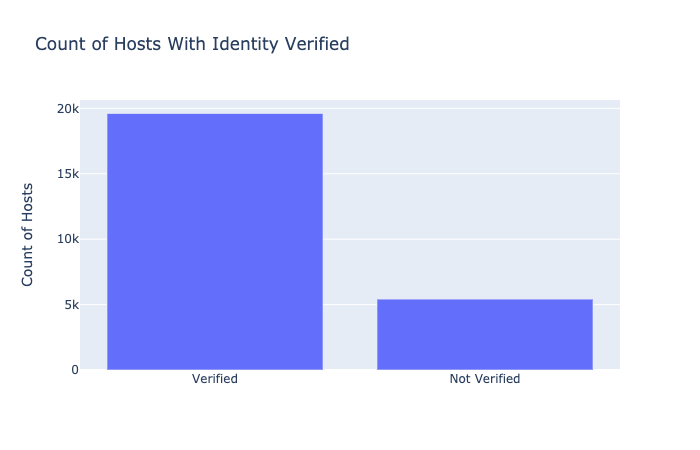

In [621]:
fig = go.Figure([go.Bar(x=labels, y=identity_verified_df['host_count'])])

fig.update_layout(title='Count of Hosts With Identity Verified', yaxis_title='Count of Hosts')

fig.write_html('identity_verified_count_plot.html')

fig.show()

# Image(filename='../plt_11.png') 

**What are the top 5 hosts and their locations?**

The below visualization shows the locations of Airbnb listings belonging to the top 5 hosts based on the number of listings that they have on the site. The top host, Stay With Vibe, has 103 listings all over Manhattan. These listings primarily cost less than $200 per night.

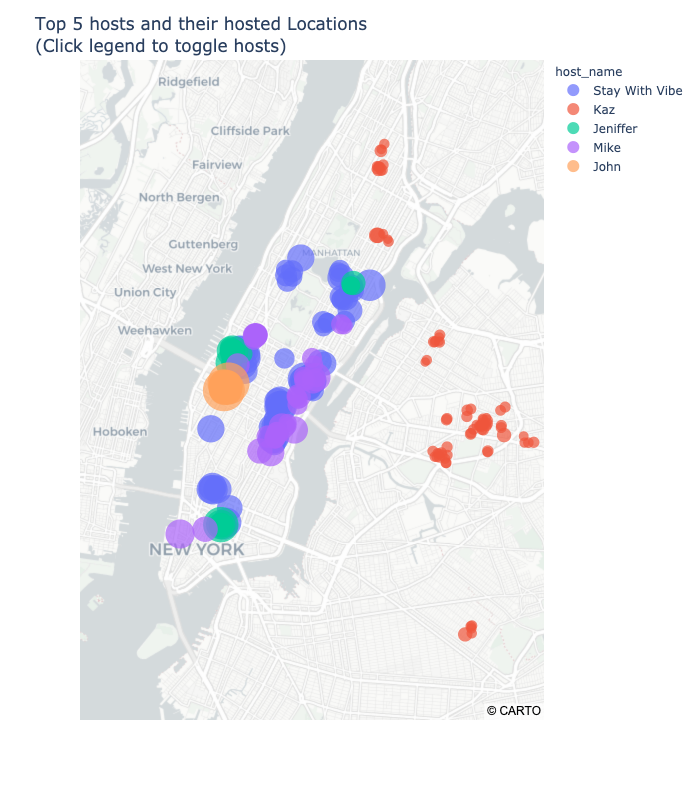

In [622]:
sub5 = listings.host_id.value_counts().reset_index().head(5)
sub5.columns = ['host_id', 'count']
sub5 = sub5.merge(listings[['host_id','host_name','price', 'latitude','longitude']], left_on = 'host_id',right_on = 'host_id', how = 'left', copy = False)
fig = px.scatter_mapbox(sub5,lat="latitude",lon="longitude",color="host_name",size="price",size_max=30,opacity = .70,zoom=11)
fig.layout.mapbox.style = 'carto-positron'
fig.update_layout(title_text = 'Top 5 hosts and their hosted Locations<br>(Click legend to toggle hosts)', height = 800)
fig.show()

Image(filename='../plt_6.png') 

## Reviews Analysis

**When was the oldest comment posted and when was the latest posted?**  
The oldest comment was posted on April 23, 2009 and the latest was posted on October 11, 2020

In [506]:
print(reviews.date.min())
print(reviews.date.max())

2009-04-23 00:00:00
2020-10-11 00:00:00


**How many reviews were there in each year?**  
The number of comments posted increased over time and 2019 has the most comments posted. After COVID outbreak, the number of comments posted dropped. This is most likely the result of travel restrictions and the decrease in demand for rooms.

In [507]:
reviews.groupby('year')['comments'].count()

year
2009       108
2010       810
2011      3392
2012      7271
2013     14254
2014     28676
2015     57739
2016    101610
2017    149566
2018    222928
2019    313366
2020    100438
Name: comments, dtype: int64

Here is a visualization of this trend. We can see a drastic change in number between 2019 and 2020.

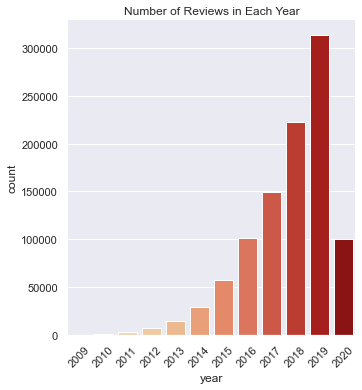

In [508]:
sns.catplot(x='year', data=reviews, kind='count', palette='OrRd')
plt.xticks(rotation=45)
plt.title("Number of Reviews in Each Year")
plt.show();

**How many comments were posted each month in 2019 and 2020?**  
Below is a visualization of the distribution of the number of comments posted in 2019 and 2020. We can see that September, October and December usually have the most comments posted.

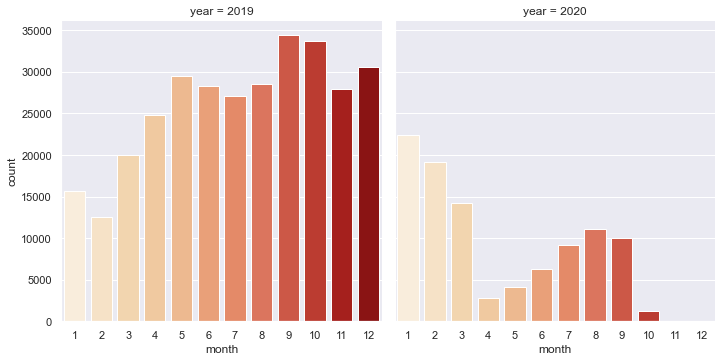

In [509]:
reviews_19_20 = reviews[(reviews['year']==2019) | (reviews['year']==2020)]
sns.catplot(x='month', data=reviews_19_20, kind='count', col='year', palette='OrRd')
plt.show();

**A glimpse into what the top reviewers said:**  
Reviewer ID 111293458 posted the most comments throughout the years. Below is a word cloud of the comments she left.

<Figure size 720x576 with 0 Axes>

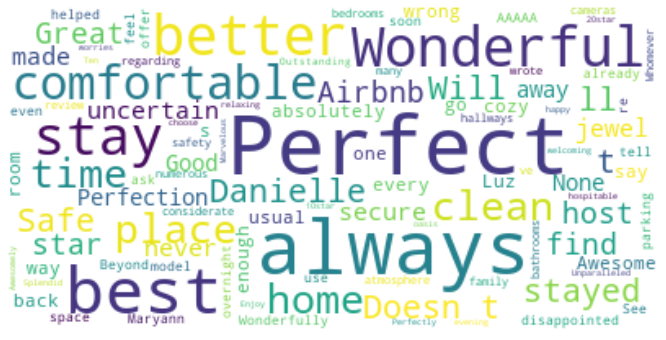

In [510]:
comments = reviews[reviews['reviewer_id']==111293458]['comments'].reset_index()

text = ""
for i in range(len(comments)):
    text = text + " " + str(comments['comments'][i])

stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stopwords, background_color="white").generate(text)
plt.figure()
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

**A glimpse into the comments that the top listing received:**  
Listing ID 32678719 received the most comments throughout the years. Below is a word cloud of the comments. It appears that this listing (presumably near Times Square) received more comments on its "great location", cleaniness, and other compliments.

<Figure size 720x576 with 0 Axes>

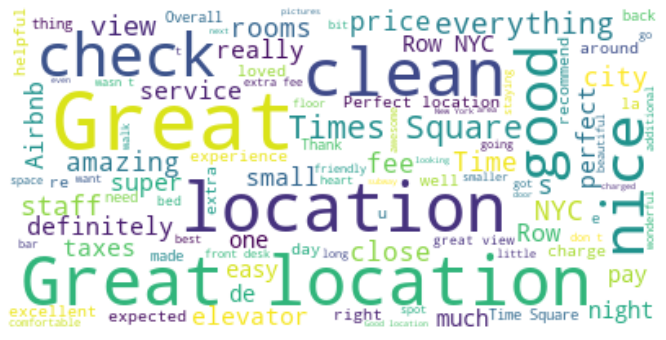

In [511]:
listing_review = reviews[reviews['listing_id']==32678719]['comments'].reset_index()

text = ""
for i in range(len(listing_review)):
    text = text + " " + str(listing_review['comments'][i])

stopwords = set(STOPWORDS)
stopwords.add('room')
stopwords.add('hotel')
stopwords.add('place')
stopwords.add('will')
stopwords.add('stay')
wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stopwords, background_color="white").generate(text)
plt.figure()
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

**A glimpse into the comments received by the listings with the lowest rating:**  
The lowest average rating is 20 and there are 137 listings who received it. It appears that most comments these listings received were complaints against the hosts, reservations being cancelled, and the bathrooms.

<Figure size 720x576 with 0 Axes>

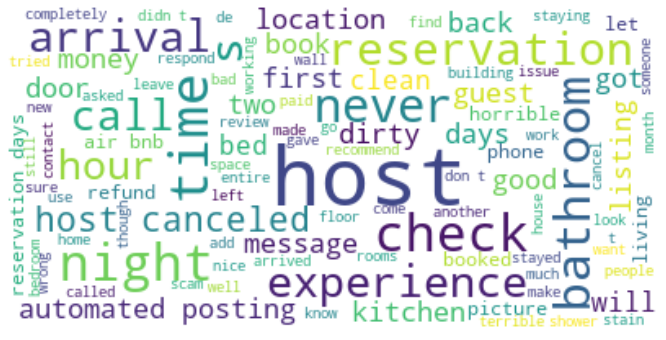

In [512]:
lowest = listings.review_scores_rating.min()
worst_id = listings[listings.review_scores_rating==lowest]['id']
worst_review = reviews[reviews['listing_id'].isin(worst_id)]['comments'].reset_index()

text = ""
for i in range(len(worst_review)):
    text = text + " " + str(worst_review['comments'][i])

stopwords = set(STOPWORDS)
stopwords.add('Airbnb')
stopwords.add('place')
stopwords.add('said')
stopwords.add('really')
stopwords.add('us')
stopwords.add('even')
stopwords.add('told')
stopwords.add('one')
stopwords.add('apartment')
stopwords.add('hotel')
stopwords.add('room')
stopwords.add('day')
stopwords.add('stay')
wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stopwords, background_color="white").generate(text)
plt.figure()
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

##  Calendar Analysis

In [513]:
calendar_2019_super_ts = calendar_2019_super.groupby("date").agg({"price":"mean"}).reset_index()
calendar_2019_not_super_ts =calendar_2019_not_super.groupby("date").agg({"price":"mean"}).reset_index()

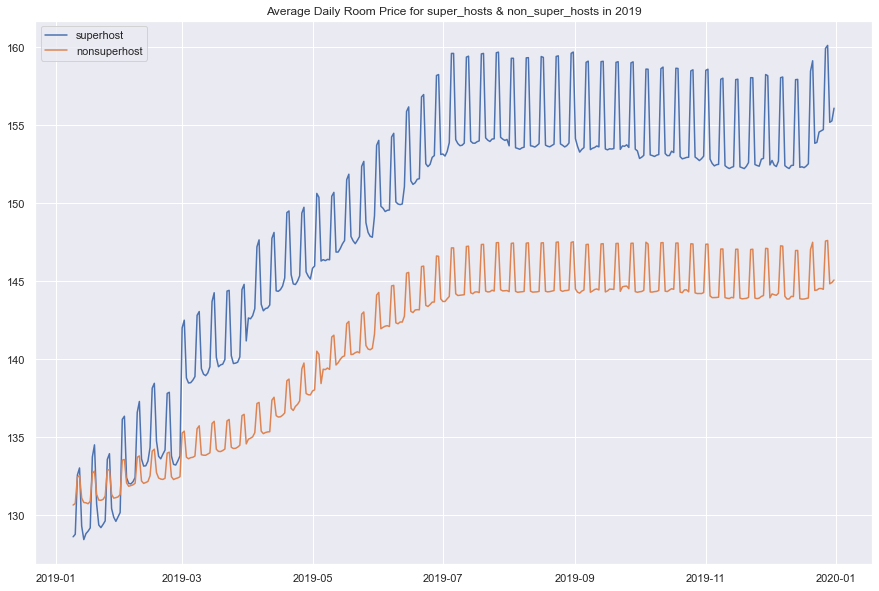

In [514]:
fig, axes = plt.subplots(figsize=(15,10))  
axes.plot(calendar_2019_super_ts["date"],calendar_2019_super_ts["price"],label="superhost")
axes.plot(calendar_2019_not_super_ts["date"],calendar_2019_not_super_ts["price"],label="nonsuperhost")
axes.set_title("Average Daily Room Price for super_hosts & non_super_hosts in 2019")
plt.legend()
plt.show()

**How COVID-19 affect hosts' prediction about their room price?**

* From this chart we can see that in January, when COVID-19 didn't hit U.S., hosts' prediction about their room price follows the trends we saw earlier. 
* When it comes to March, hosts' prediction about their room price in March is lower than what they expected in January. It increased a little in April, and went back to normal in May. 
* When it came to July, hosts' prediction about their room price in July is much lower than what they expected in January and March, it went back to normal in December.

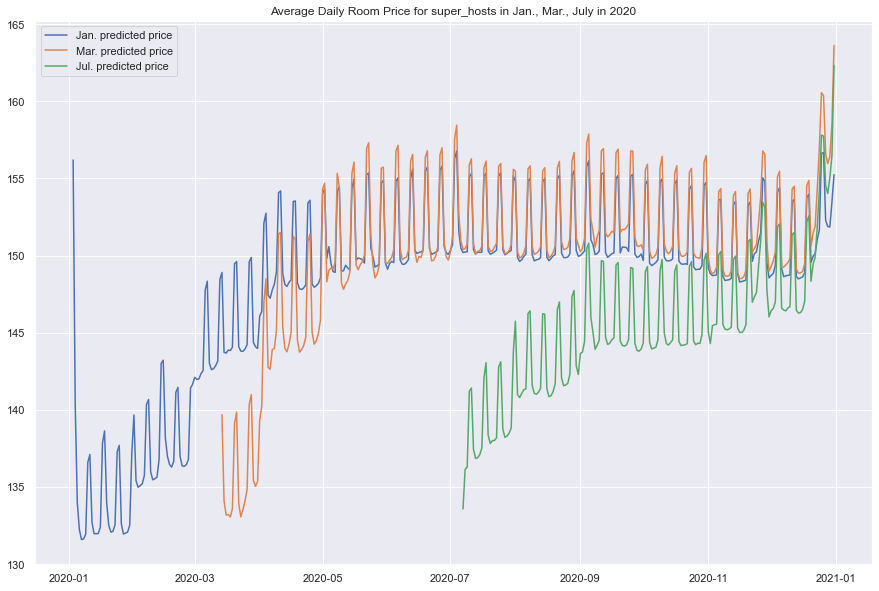

In [515]:
fig, axes = plt.subplots(figsize=(15,10))  
axes.plot(calendar_2020_1_f["date"],calendar_2020_1_f["price"],label="Jan. predicted price")
axes.plot(calendar_2020_3_f["date"],calendar_2020_3_f["price"],label="Mar. predicted price")
axes.plot(calendar_2020_7_f["date"],calendar_2020_7_f["price"],label="Jul. predicted price")
axes.set_title("Average Daily Room Price for super_hosts in Jan., Mar., July in 2020")
plt.legend()
plt.show()

**Does hosts' prediction about their average price follow the same trend in 2019?**
 
In 2019, we can see that average room price hosts predicted in March and July is a little different than what they predicted in January. However, we think the price fluctuation is reasonable. So based on this, we assume COVID-19 situation affect the average room price. 

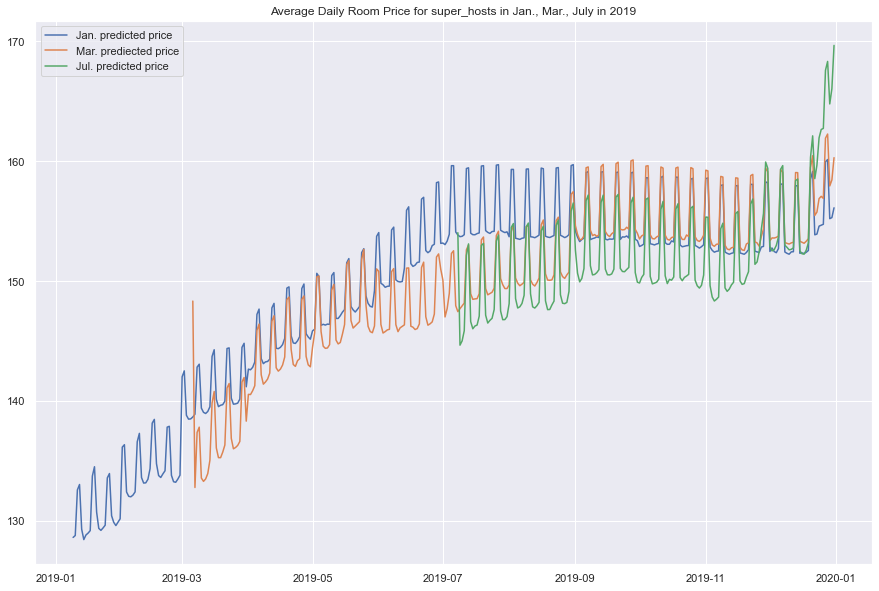

In [516]:
fig, axes = plt.subplots(figsize=(15,10))  
axes.plot(calendar_2019_super_ts["date"],calendar_2019_super_ts["price"],label="Jan. predicted price")
axes.plot(calendar_2019_3_f["date"],calendar_2019_3_f["price"],label="Mar. prediected price")
axes.plot(calendar_2019_7_f["date"],calendar_2019_7_f["price"],label="Jul. predicted price")
axes.set_title("Average Daily Room Price for super_hosts in Jan., Mar., July in 2019")
plt.legend()
plt.show()

# Machine Learning Models

## Classification

In this model, we will predict whether a host is a superhost based on the available features in the dataset.

In [517]:
# make a copy of the dataframe
model_df = listings.copy()

In [518]:
# fill any na values with 0
model_df.is_superhost_numeric = model_df.is_superhost_numeric.fillna(0)

Next, we drop columns that we don't believe will have any predictive power, or are duplicates of other converted columns. There are a number of columns that are URL string, for example, listing_url and picture_url, both of which would not have contributed to the model. A few of the columns, including host_response_rate and host_acceptance_rate have a very large number of missing values, and we do not feel that we had enough information available to impute the missing values accuratly. Also, a few of the columns, including host_neighbourhood, neighbourhood and neighbourhood_cleansed, have a lot of different values which would result in a lot of additional columns when creating dummy variables, and these columns also contain messy string data. There are also some datetime columns, including first_review and last_review. We chose to drop these since there are a very large number of unique values in these columns, and we don't believe that they have any predictive power.

In [519]:
model_cols = model_df.drop(columns=['id','listing_url','last_scraped','name','description','neighborhood_overview','picture_url','host_url','host_name','host_since','host_location','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood','host_verifications','neighbourhood','neighbourhood_cleansed','property_type','bathrooms_text','amenities','first_review','last_review','price','host_identity_verified','host_has_profile_pic','host_is_superhost','host_response_rate','host_acceptance_rate','host_listings_count', 'host_identity_verified_numeric'], axis=1)

df_listing_dummied = pd.get_dummies(model_cols, columns=['host_response_time','neighbourhood_group_cleansed','room_type','has_availability','instant_bookable'], drop_first=True)

#### Feature Engineering and Model Building 

There are many columns that are sepcific to a listing, but not global to a host. In this section, we will convert a number of columns to be an aggregation per host. For example, we will find the average_availability_30 across all of the listings for each host so that we have one value for each host.

When aggregating, we chose to take the sum of some values, and the mean of others. We chose to calculate the mean for the availability related columns in order to find the average availability for each host across all their listings. For the review socre features, we took the avarage because we felt that summing the score would not make sense in the context. We took the sum of the reviews since we felt it would make sense to calculate a total number of reviews per host.

We wanted to include the bourough for each listing as well, since we thought that the location may be correlated to being a superhost. Since this feature has 5 levels (5 different bouroughs), we eneded up with 5 different columns after generating dummy variables. We then created new columns where for each bourough, there is an average number of listings for a particular host in each bourough. Since there are many hosts with multiple listings in different bouroughs, these values could potentially be decimals.

In [520]:
# convert average_availability_30
average_availability_30_per_host = df_listing_dummied.groupby('host_id')['availability_30'].mean()
average_availability_30_per_host = pd.DataFrame(average_availability_30_per_host)
average_availability_30_per_host = average_availability_30_per_host.reset_index()
average_availability_30_per_host = average_availability_30_per_host.rename(columns={"availability_30": "average_availability_30_per_host"})

df_listing_dummied = df_listing_dummied.merge(average_availability_30_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='availability_30', axis=1)

In [521]:
# convert average_availability_60
average_availability_60_per_host = df_listing_dummied.groupby('host_id')['availability_60'].mean()
average_availability_60_per_host = pd.DataFrame(average_availability_60_per_host)
average_availability_60_per_host = average_availability_60_per_host.reset_index()
average_availability_60_per_host = average_availability_60_per_host.rename(columns={"availability_60": "average_availability_60_per_host"})

df_listing_dummied = df_listing_dummied.merge(average_availability_60_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='availability_60', axis=1)

In [522]:
# convert average_availability_90
average_availability_90_per_host = df_listing_dummied.groupby('host_id')['availability_90'].mean()
average_availability_90_per_host = pd.DataFrame(average_availability_90_per_host)
average_availability_90_per_host = average_availability_90_per_host.reset_index()
average_availability_90_per_host = average_availability_90_per_host.rename(columns={"availability_90": "average_availability_90_per_host"})

df_listing_dummied = df_listing_dummied.merge(average_availability_90_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='availability_90', axis=1)

In [523]:
# convert average_availability_365
average_availability_365_per_host = df_listing_dummied.groupby('host_id')['availability_365'].mean()
average_availability_365_per_host = pd.DataFrame(average_availability_365_per_host)
average_availability_365_per_host = average_availability_365_per_host.reset_index()
average_availability_365_per_host = average_availability_365_per_host.rename(columns={"availability_365": "average_availability_365_per_host"})

df_listing_dummied = df_listing_dummied.merge(average_availability_365_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='availability_365', axis=1)

In [524]:
# convert number of reviews
total_number_of_reviews_per_host = df_listing_dummied.groupby('host_id')['number_of_reviews'].sum()
total_number_of_reviews_per_host = pd.DataFrame(total_number_of_reviews_per_host)
total_number_of_reviews_per_host = total_number_of_reviews_per_host.reset_index()
total_number_of_reviews_per_host = total_number_of_reviews_per_host.rename(columns={"number_of_reviews": "total_number_of_reviews_per_host"})

df_listing_dummied = df_listing_dummied.merge(total_number_of_reviews_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='number_of_reviews', axis=1)

In [525]:
# convert number of reviews_ltm
total_number_of_reviews_ltm_per_host = df_listing_dummied.groupby('host_id')['number_of_reviews_ltm'].sum()
total_number_of_reviews_ltm_per_host = pd.DataFrame(total_number_of_reviews_ltm_per_host)
total_number_of_reviews_ltm_per_host = total_number_of_reviews_ltm_per_host.reset_index()
total_number_of_reviews_ltm_per_host = total_number_of_reviews_ltm_per_host.rename(columns={"number_of_reviews_ltm": "total_number_of_reviews_ltm_per_host"})

df_listing_dummied = df_listing_dummied.merge(total_number_of_reviews_ltm_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='number_of_reviews_ltm', axis=1)

In [526]:
# convert number_of_reviews_l30d 
total_number_of_reviews_l30d_per_host = df_listing_dummied.groupby('host_id')['number_of_reviews_l30d'].sum()
total_number_of_reviews_l30d_per_host = pd.DataFrame(total_number_of_reviews_l30d_per_host)
total_number_of_reviews_l30d_per_host = total_number_of_reviews_l30d_per_host.reset_index()
total_number_of_reviews_l30d_per_host = total_number_of_reviews_l30d_per_host.rename(columns={"number_of_reviews_l30d": "total_number_of_reviews_l30d_per_host"})

df_listing_dummied = df_listing_dummied.merge(total_number_of_reviews_l30d_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='number_of_reviews_l30d', axis=1)

In [527]:
# convert review_scores_rating
avg_review_scores_rating_per_host = df_listing_dummied.groupby('host_id')['review_scores_rating'].mean()
avg_review_scores_rating_per_host = pd.DataFrame(avg_review_scores_rating_per_host)
avg_review_scores_rating_per_host = avg_review_scores_rating_per_host.reset_index()
avg_review_scores_rating_per_host = avg_review_scores_rating_per_host.rename(columns={"review_scores_rating": "avg_review_scores_rating_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_review_scores_rating_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='review_scores_rating', axis=1)

In [528]:
# convert review_scores_accuracy
avg_review_scores_accuracy_per_host = df_listing_dummied.groupby('host_id')['review_scores_accuracy'].mean()
avg_review_scores_accuracy_per_host = pd.DataFrame(avg_review_scores_accuracy_per_host)
avg_review_scores_accuracy_per_host = avg_review_scores_accuracy_per_host.reset_index()
avg_review_scores_accuracy_per_host = avg_review_scores_accuracy_per_host.rename(columns={"review_scores_accuracy": "avg_review_scores_accuracy_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_review_scores_accuracy_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='review_scores_accuracy', axis=1)

In [529]:
# convert review_scores_cleanliness
avg_review_scores_cleanliness_per_host = df_listing_dummied.groupby('host_id')['review_scores_cleanliness'].mean()
avg_review_scores_cleanliness_per_host = pd.DataFrame(avg_review_scores_cleanliness_per_host)
avg_review_scores_cleanliness_per_host = avg_review_scores_cleanliness_per_host.reset_index()
avg_review_scores_cleanliness_per_host = avg_review_scores_cleanliness_per_host.rename(columns={"review_scores_cleanliness": "avg_review_scores_cleanliness_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_review_scores_cleanliness_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='review_scores_cleanliness', axis=1)

In [530]:
# convert review_scores_checkin
avg_review_scores_checkin_per_host = df_listing_dummied.groupby('host_id')['review_scores_checkin'].mean()
avg_review_scores_checkin_per_host = pd.DataFrame(avg_review_scores_checkin_per_host)

avg_review_scores_checkin_per_host = avg_review_scores_checkin_per_host.reset_index()

avg_review_scores_checkin_per_host = avg_review_scores_checkin_per_host.rename(columns={"review_scores_checkin": "avg_review_scores_checkin_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_review_scores_checkin_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='review_scores_checkin', axis=1)

In [531]:
# convert review_scores_communication
avg_review_scores_communication_per_host = df_listing_dummied.groupby('host_id')['review_scores_communication'].mean()
avg_review_scores_communication_per_host = pd.DataFrame(avg_review_scores_communication_per_host)
avg_review_scores_communication_per_host = avg_review_scores_communication_per_host.reset_index()
avg_review_scores_communication_per_host = avg_review_scores_communication_per_host.rename(columns={"review_scores_communication": "avg_review_scores_checkin_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_review_scores_communication_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='review_scores_communication', axis=1)

In [532]:
# convert review_scores_location
avg_review_scores_location_per_host = df_listing_dummied.groupby('host_id')['review_scores_location'].mean()
avg_review_scores_location_per_host = pd.DataFrame(avg_review_scores_location_per_host)
avg_review_scores_location_per_host = avg_review_scores_location_per_host.reset_index()
avg_review_scores_location_per_host = avg_review_scores_location_per_host.rename(columns={"review_scores_location": "avg_review_scores_location_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_review_scores_location_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='review_scores_location', axis=1)

In [533]:
# convert review_scores_value 
avg_review_scores_value_per_host = df_listing_dummied.groupby('host_id')['review_scores_value'].mean()
avg_review_scores_value_per_host = pd.DataFrame(avg_review_scores_value_per_host)
avg_review_scores_value_per_host = avg_review_scores_value_per_host.reset_index()
avg_review_scores_value_per_host = avg_review_scores_value_per_host.rename(columns={"review_scores_value": "avg_review_scores_value_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_review_scores_value_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='review_scores_value', axis=1)

In [534]:
# convert reviews_per_month
avg_reviews_per_month_per_host = df_listing_dummied.groupby('host_id')['reviews_per_month'].mean()
avg_reviews_per_month_per_host = pd.DataFrame(avg_reviews_per_month_per_host)
avg_reviews_per_month_per_host = avg_reviews_per_month_per_host.reset_index()
avg_reviews_per_month_per_host = avg_reviews_per_month_per_host.rename(columns={"reviews_per_month": "avg_reviews_per_month_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_reviews_per_month_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='reviews_per_month', axis=1)

In [535]:
# convert neighbourhood_group_cleansed_Brooklyn
avg_Brooklyn_per_host = df_listing_dummied.groupby('host_id')['neighbourhood_group_cleansed_Brooklyn'].mean()
avg_Brooklyn_per_host = pd.DataFrame(avg_Brooklyn_per_host)
avg_Brooklyn_per_host = avg_Brooklyn_per_host.reset_index()
avg_Brooklyn_per_host = avg_Brooklyn_per_host.rename(columns={"neighbourhood_group_cleansed_Brooklyn": "avg_Brooklyn_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_Brooklyn_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='neighbourhood_group_cleansed_Brooklyn', axis=1)

In [536]:
# convert neighbourhood_group_cleansed_Manhattan
avg_Manhattan_per_host = df_listing_dummied.groupby('host_id')['neighbourhood_group_cleansed_Manhattan'].mean()
avg_Manhattan_per_host = pd.DataFrame(avg_Manhattan_per_host)
avg_Manhattan_per_host = avg_Manhattan_per_host.reset_index()
avg_Manhattan_per_host = avg_Manhattan_per_host.rename(columns={"neighbourhood_group_cleansed_Manhattan": "avg_Brooklyn_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_Manhattan_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='neighbourhood_group_cleansed_Manhattan', axis=1)

In [537]:
# convert neighbourhood_group_cleansed_Queens
avg_Queens_per_host = df_listing_dummied.groupby('host_id')['neighbourhood_group_cleansed_Queens'].mean()
avg_Queens_per_host = pd.DataFrame(avg_Queens_per_host)
avg_Queens_per_host = avg_Queens_per_host.reset_index()
avg_Queens_per_host = avg_Queens_per_host.rename(columns={"neighbourhood_group_cleansed_Queens": "avg_Queens_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_Manhattan_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='neighbourhood_group_cleansed_Queens', axis=1)

In [538]:
# convert neighbourhood_group_cleansed_Staten Island
avg_Staten_Island_per_host = df_listing_dummied.groupby('host_id')['neighbourhood_group_cleansed_Staten Island'].mean()
avg_Staten_Island_per_host = pd.DataFrame(avg_Staten_Island_per_host)
avg_Staten_Island_per_host = avg_Staten_Island_per_host.reset_index()
avg_Staten_Island_per_host = avg_Staten_Island_per_host.rename(columns={"neighbourhood_group_cleansed_Staten Island": "avg_Staten_Island_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_Staten_Island_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='neighbourhood_group_cleansed_Staten Island', axis=1)

In [539]:
# convert room_type_Hotel room
avg_room_type_Hotel_room_per_host = df_listing_dummied.groupby('host_id')['room_type_Hotel room'].mean()
avg_room_type_Hotel_room_per_host = pd.DataFrame(avg_room_type_Hotel_room_per_host)
avg_room_type_Hotel_room_per_host = avg_room_type_Hotel_room_per_host.reset_index()
avg_room_type_Hotel_room_per_host = avg_room_type_Hotel_room_per_host.rename(columns={"room_type_Hotel room": "avg_room_type_Hotel_room_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_room_type_Hotel_room_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='room_type_Hotel room', axis=1)

In [540]:
# convert room_type_Private room
avg_room_type_Private_room_per_host = df_listing_dummied.groupby('host_id')['room_type_Private room'].mean()
avg_room_type_Private_room_per_host = pd.DataFrame(avg_room_type_Private_room_per_host)
avg_room_type_Private_room_per_host = avg_room_type_Private_room_per_host.reset_index()
avg_room_type_Private_room_per_host = avg_room_type_Private_room_per_host.rename(columns={"room_type_Private room": "avg_room_type_Private_room_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_room_type_Private_room_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='room_type_Private room', axis=1)

In [541]:
# convert room_type_Shared room
avg_room_type_Shared_room_per_host = df_listing_dummied.groupby('host_id')['room_type_Shared room'].mean()
avg_room_type_Shared_room_per_host = pd.DataFrame(avg_room_type_Shared_room_per_host)
avg_room_type_Shared_room_per_host = avg_room_type_Shared_room_per_host.reset_index()
avg_room_type_Shared_room_per_host = avg_room_type_Shared_room_per_host.rename(columns={"room_type_Shared room": "avg_room_type_Shared_room_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_room_type_Shared_room_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='room_type_Shared room', axis=1)

In [542]:
# convert instant_bookable_t
avg_instant_bookable_t_per_host = df_listing_dummied.groupby('host_id')['instant_bookable_t'].mean()
avg_instant_bookable_t_per_host = pd.DataFrame(avg_instant_bookable_t_per_host)
avg_instant_bookable_t_per_host = avg_instant_bookable_t_per_host.reset_index()
avg_instant_bookable_t_per_host = avg_instant_bookable_t_per_host.rename(columns={"instant_bookable_t": "avg_instant_bookable_t_per_host"})

df_listing_dummied = df_listing_dummied.merge(avg_instant_bookable_t_per_host, on='host_id')

df_listing_dummied = df_listing_dummied.drop(columns='instant_bookable_t', axis=1)

In [543]:
# convert from object type to category to prepare for model creation
df_listing_dummied.is_superhost_numeric = df_listing_dummied.is_superhost_numeric.astype('category')
# df_listing_dummied.host_identity_verified_numeric = df_listing_dummied.host_identity_verified_numeric.astype('category')

In [544]:
# eliminate duplicate host_id
column_name = ['host_id']
hosts_model_df = df_listing_dummied.sort_values('host_id').drop_duplicates(subset=column_name)

#### Creating a KNN model

In the first model, we chose to use all of the available features. We calculated a low sensativity score, revealing that this model is not good at differentiating between superhost and non-superhost. We then ran a Random Forest Classifier to find the most important features. We then created a second model with only the top few features and were able to calculate a much higher sensativity score.

In [545]:
# features matrix
X = hosts_model_df.drop('is_superhost_numeric', axis=1)  
# target vector
y = hosts_model_df['is_superhost_numeric']

# split the data into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=833)

In [546]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xtrain, ytrain)
y_model = knn.predict(Xtest)
# number who superhosts
P = sum(ytest == 1)
# total number of hosts in the dataset
n_test = len(ytest)
# the number that we correcty predicted as superhosts
TP = sum((ytest == 1) & (y_model == 1))
# sensativity
TPR = TP/P

In [547]:
TPR

0.127420362273579

In [548]:
# the total number in the dataset that are not super hosts
N = sum(ytest == 0)
# true negative, or the number that we correctly identified as not super hosts
TN = sum((ytest == 0) & (y_model == 0))
# the true negative rate (Specificity)
TNR = TN/N
# a false positive (the total positives - the correclty predicted positives = the falsly predicted postives)
FP = P-TP
FP
# a false negative (the total negatives - the correclty predicted negatives = the falsly predicted negatives)
FN = N-TN
FN

677

In [549]:
# Calculate an overal accuracy score
accuracy_score(ytest, y_model)

0.7239084132055378

The confusion matrix below displays the true positive, true negative, false negative, and false poitive rates that resulted from running the model with all of the features. There were a large number of false positive where we predicted that a host was a superhost when they were actually not. For this reason, we chose to run a Random Forest Classifier to determine the most important features required for the classification model.

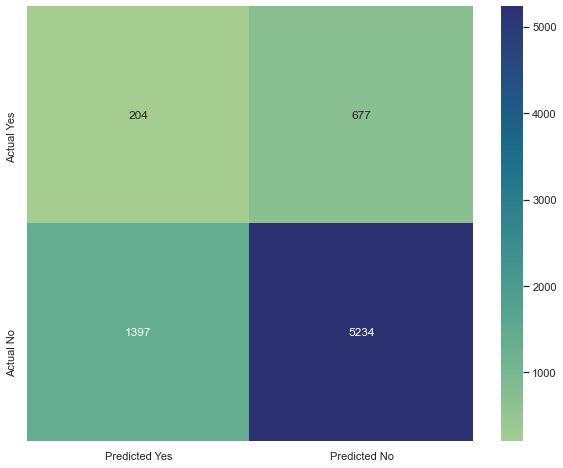

In [550]:
data=[[TP, FN], [FP, TN]]
heatmap_data = pd.DataFrame(data)
heatmap_data.columns = ['Predicted Yes', 'Predicted No']
heatmap_data.index = ['Actual Yes', 'Actual No']
sns.heatmap(heatmap_data, annot=True, cmap="crest", fmt='d')

The Random Forest Classifier reveals that the most important features are review related. For example, the total number of reviews that a host has in the last 12 months is the most important feature. The average number of reviews per month, as well as their cleanliness, their review score, and accuracy scores are also important. According to AirBnb ([AirBnb Superhost Requirements](https://www.airbnb.com/help/article/829/how-do-i-become-a-superhost)), a Superhost should have at least a 4.8 overall rating over the last year, and our Random Forest output reiterates this point. There is also a requirement to have at least 10 reservations in the last year. Our results below are aligned with AirBnb's policies which states that  the number of reviews and quality of reviews are very important in determining if a host becomes a superhost. 

This analysis also reveals how important it is for AirBnb hosts to maintain glowing reviews since AirBnb will take this into account when selecting hosts to become Superhosts. Also, it is important for a host to receive a large number of reviews, and to have at least 10 reservations within the last year.

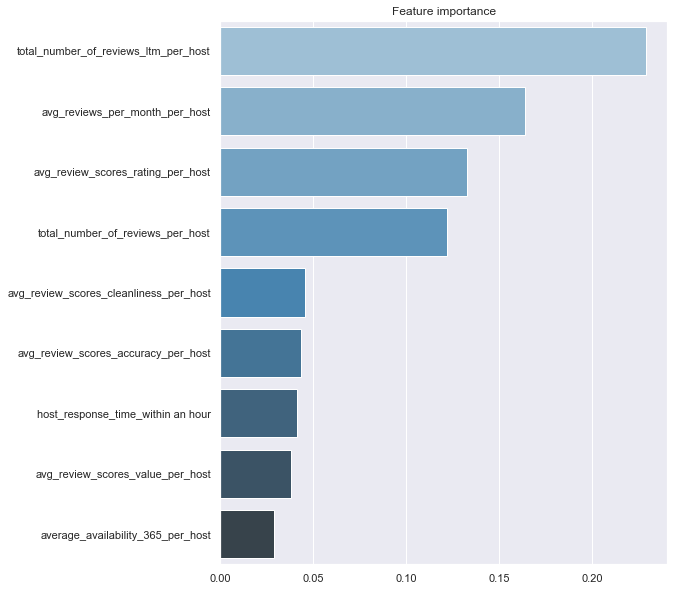

In [551]:
# determining the most important features using RandomForestClassifier
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}

# Drop redundant columns (for features with two unique values)
drop = ['is_superhost_numeric']
x, y = hosts_model_df.drop(drop,axis=1), hosts_model_df['is_superhost_numeric']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(8,10))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index[:9], x=imp.values[:9], palette="Blues_d", orient='h')

We noticed that the average Brooklyn per host feature appeared in the random forest ranking (even though we didn't include it in the model because it was not very significant). We were curious to know why this particular bourough appeared, but other were not even significant enough to appear on the chart at all. After creating a barchart of the number of superhosts per bourough, we discovered that there are a large number of superhosts in Brooklyn.

In [552]:
host_count = pd.DataFrame(hosts[hosts.is_superhost_numeric == 1].groupby('neighbourhood_group_cleansed')['host_id'].count()).reset_index()
host_count.columns = ['neighborhood','count']

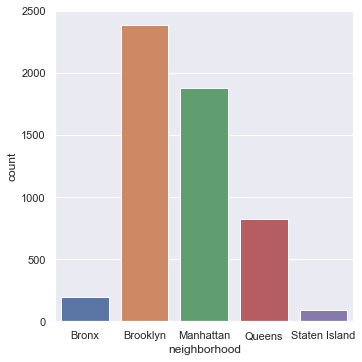

In [553]:
sns.catplot(data= host_count, x='neighborhood',y='count', kind='bar')

In [554]:
# subset the df for only the most important features
model_2_df = hosts_model_df[['is_superhost_numeric','total_number_of_reviews_ltm_per_host','avg_reviews_per_month_per_host','total_number_of_reviews_per_host','avg_review_scores_rating_per_host', 'host_response_time_within an hour','avg_review_scores_cleanliness_per_host','avg_review_scores_accuracy_per_host']]

In [587]:
# features matrix
X = model_2_df.drop('is_superhost_numeric', axis=1)  
# target vector
y = model_2_df['is_superhost_numeric']

# split the data into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=833)

In [588]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xtrain, ytrain)
y_model = knn.predict(Xtest)
# number who are superhosts
P = sum(ytest == 1)
# total number of hosts in the dataset
n_test = len(ytest)
# the number that we correcty predicted as superhosts
TP = sum((ytest == 1) & (y_model == 1))
# sensativity
TPR = TP/P

In [589]:
# an improved sensitivity score of 62.96%
TPR

0.6296064959400375

In [590]:
accuracy_score(ytest, y_model)

0.8505058572949947

In [591]:
# the total number in the dataset that are not super hosts
N = sum(ytest == 0)
# true negative, or the number that we correctly identified as not super hosts
TN = sum((ytest == 0) & (y_model == 0))
# the true negative rate (Specificity)
TNR = TN/N
# a false positive (the total positives - the correclty predicted positives = the falsly predicted postives)
FP = P-TP
FP
# a false negative (the total negatives - the correclty predicted negatives = the falsly predicted negatives)
FN = N-TN
FN

530

#### Model Results

By selecting only the first few most important features, we were able to improve our model. We are now able to achieve a much higher sensativity score. There were a total of 1008 hosts that we correctly predicted as superhosts. The confusion matrix below displays the true positive, true negative, false negative, and false poitive rates that resulted from running the model with all of the features. The matrix displays a much lower number of false positives compared to the previous model.

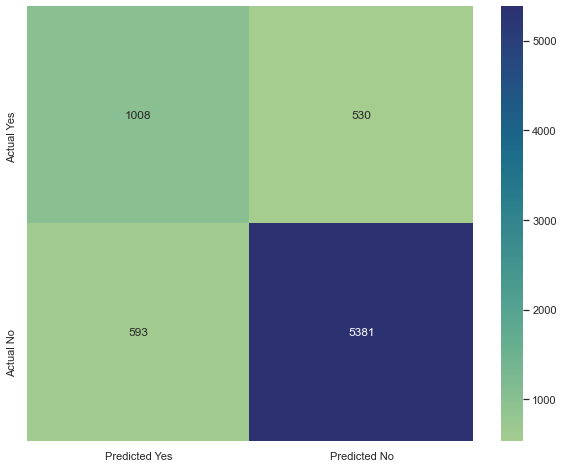

In [592]:
# create a heatmap showing the results
data=[[TP, FN], [FP, TN]]
heatmap_data = pd.DataFrame(data)
heatmap_data.columns = ['Predicted Yes', 'Predicted No']
heatmap_data.index = ['Actual Yes', 'Actual No']
sns.heatmap(heatmap_data, annot=True, cmap="crest", fmt='d')

## Linear Regression

- Creating a new DataFrame called 'data' that will be used for our Linear Regression model. 
- Dropping features that do not have predictive power, following a similar rationale as that of removing features while building our classification model above.

In [561]:
data = listings.copy()

In [562]:
data.drop(['name', 'description', 'host_name', 'host_since', 'neighborhood_overview', 'host_location', 'id', 'listing_url', 'picture_url', 'host_id', 'host_url', 'host_about', 'host_response_rate',  'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_verifications', 'neighbourhood', 'neighbourhood_cleansed', 'amenities', 'has_availability', 'first_review',
       'last_review', 'host_identity_verified', 'last_scraped', 'host_response_time', 'host_acceptance_rate', 'host_acceptance_rate', 'bathrooms_text', 'host_has_profile_pic', 'host_listings_count', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'host_identity_verified_numeric','latitude', 'longitude', 'property_type'], inplace=True, axis=1)

In [563]:
# examining the dataframe to identify missing values. We find that is_superhost_numeric has a few missing values.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31880 entries, 0 to 44640
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  31880 non-null  object 
 1   room_type                     31880 non-null  object 
 2   accommodates                  31880 non-null  int64  
 3   bedrooms                      31880 non-null  float64
 4   beds                          31880 non-null  float64
 5   price                         31880 non-null  float64
 6   availability_30               31880 non-null  int64  
 7   availability_60               31880 non-null  int64  
 8   availability_90               31880 non-null  int64  
 9   availability_365              31880 non-null  int64  
 10  number_of_reviews             31880 non-null  int64  
 11  number_of_reviews_ltm         31880 non-null  int64  
 12  number_of_reviews_l30d        31880 non-null  int64  
 13  r

In [564]:
data.beds = data.beds.astype('float32')

In [565]:
data.bedrooms = data.bedrooms.astype('float32')

In [566]:
# filling null values with zero (we are assuming that hosts with no value are not a superhost)
data["is_superhost_numeric"].fillna(0.0, inplace = True)
data.is_superhost_numeric = data.is_superhost_numeric.astype('float32')

In [567]:
# one hot encoding for categorical variables
categorical_col = []
for column in data.columns:
    if len(data[column].unique()) <= 10:
        print("===============================================================================")
        print(f"{column} : {data[column].unique()}")
        categorical_col.append(column)
        
dataset = pd.get_dummies(data, columns=['neighbourhood_group_cleansed','room_type', 'instant_bookable'], drop_first=True)

# declaring features to be scaled (through standardization) to achieve data in a standard normal structure
col_to_scale = ['accommodates', 'bedrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month']

neighbourhood_group_cleansed : ['Manhattan' 'Brooklyn' 'Queens' 'Staten Island' 'Bronx']
room_type : ['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']
review_scores_accuracy : [ 9.  8. 10.  7.  6.  2.  4.  3.  5.]
review_scores_cleanliness : [ 9.  8. 10.  7.  6.  4.  5.  2.  3.]
review_scores_checkin : [10.  9.  6.  8.  7.  2.  4.  5.  3.]
review_scores_communication : [10.  9.  7.  8.  6.  4.  2.  3.  5.]
review_scores_location : [10.  9.  8.  7.  6.  2.  4.  3.  5.]
review_scores_value : [ 9. 10.  8.  7.  6.  4.  3.  2.  5.]
instant_bookable : ['f' 't']
is_superhost_numeric : [0. 1.]


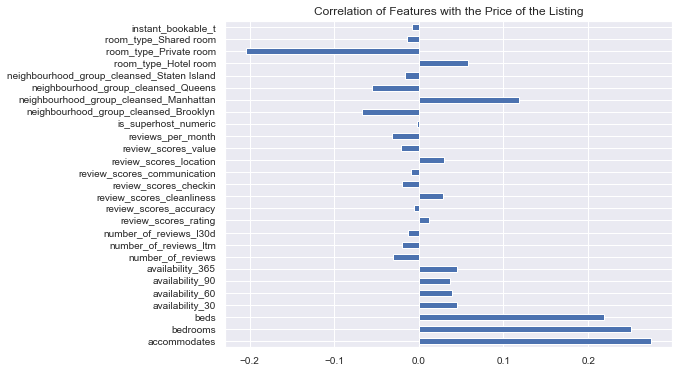

In [568]:
# using standard scaler to standardize features to achieve data that is in standard normal form
s_sc = StandardScaler()
dataset[col_to_scale] = s_sc.fit_transform(dataset[col_to_scale])

# plotting the correlation of all the features with the dependant variable (price)
dataset.drop('price', axis=1).corrwith(dataset.price).plot.barh(figsize=(8, 6), 
                                                        title='Correlation of Features with the Price of the Listing',
                                                        fontsize=10, grid=True)

#### Predicting Price For All Listings 

We are now running a linear regression model for the price of all listings.

In [569]:
# splitting the data into test and train datasets
X = dataset.drop(['price', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'], axis=1)
y = dataset['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [570]:
# the print_evaluate function is called to generate the MAE, MSE, RMSE, and R2 for in sample and out of sample
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)

In [571]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)
print("In Sample Test Dataset Prediction")
print("-------------------------------------------------------------------------------")
print_evaluate(y_train, lin_reg.predict(X_train))
print("=======================================================================================================================")
print("Out of Sample Test Dataset Prediction")
print("-------------------------------------------------------------------------------")
print_evaluate(y_test, lin_reg.predict(X_test))

In Sample Test Dataset Prediction
-------------------------------------------------------------------------------
MAE: 61.8307579261062
MSE: 49282.50884458942
RMSE: 221.996641516464
R2 Square 0.12288678537142994
Out of Sample Test Dataset Prediction
-------------------------------------------------------------------------------
MAE: 62.39911176586178
MSE: 68174.93444654635
RMSE: 261.1033022513242
R2 Square 0.08872868947300039


The in sample R2 is 12.3% due to the outliers for price as displayed in the plot below. We notice that the insample r-squared is low because the price includes outliers (price > 500). For this reason we then proceed to generate another model in which we filter for price less than $500.

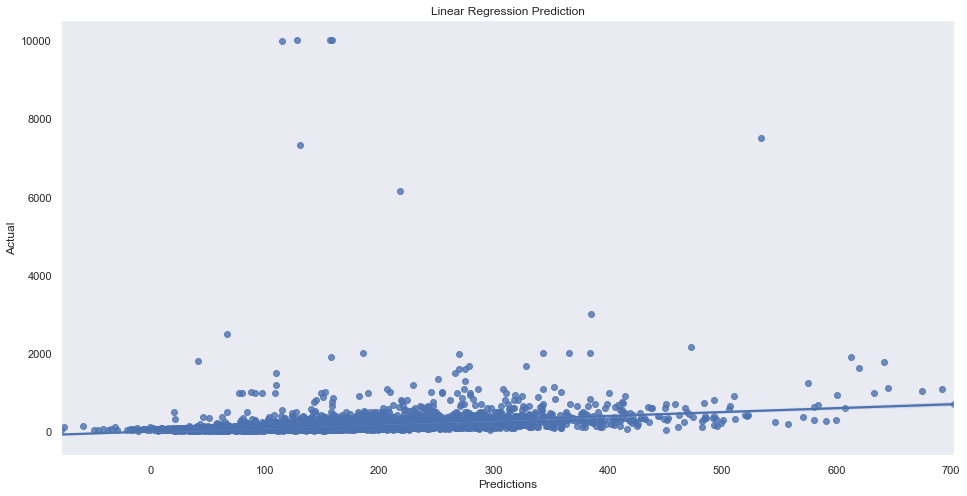

In [572]:
plt.figure(figsize=(16,8))
sns.regplot(lin_reg.predict(X_test),y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Regression Prediction")
plt.grid(False)
plt.show()

#### Predicting Price For Listings < 500 USD

We are now filtering for price less than $500 in order to remove outliers from the dataset.

In [573]:
dataset_filtered = dataset[dataset['price'] < 500]
X = dataset_filtered.drop(['price', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'], axis=1)
y = dataset_filtered['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [574]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)
print("In Sample Test Dataset Prediction")
print("-------------------------------------------------------------------------------")
print_evaluate(y_train, lin_reg.predict(X_train))
print("=======================================================================================================================")
print("Out of Sample Test Dataset Prediction")
print("-------------------------------------------------------------------------------")
print_evaluate(y_test, lin_reg.predict(X_test))

In Sample Test Dataset Prediction
-------------------------------------------------------------------------------
MAE: 39.40471331942433
MSE: 3265.6072011767965
RMSE: 57.14549152100099
R2 Square 0.4730276700420992
Out of Sample Test Dataset Prediction
-------------------------------------------------------------------------------
MAE: 39.18848882405509
MSE: 3257.137701803539
RMSE: 57.07133870695114
R2 Square 0.46519830365083703


The in sample R2 is much higher after removing the outliers. We achieved an R2 of 47.3%. However, the plot below displays some negative value predictions for price. We decided to take the log of price in order to resolve this issue as displayed in the next steps below.

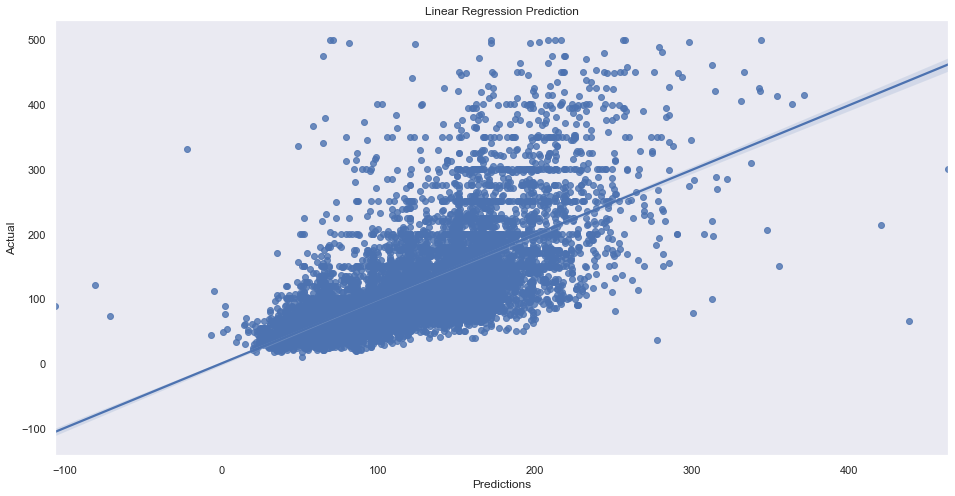

In [575]:
plt.figure(figsize=(16,8))
sns.regplot(lin_reg.predict(X_test),y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Regression Prediction")
plt.grid(False)
plt.show()

#### Predicting Price for listings less than $500 (taking the log of price)

We will now take the log of price.

In [576]:
# taking log of price and splitting data
X = dataset.drop(['price', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'], axis=1)
y = np.log(dataset['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [577]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)
print("In Sample Test Dataset Prediction")
print("-------------------------------------------------------------------------------")
print_evaluate(y_train, lin_reg.predict(X_train))
print("=======================================================================================================================")
print("Out of Sample Test Dataset Prediction")
print("-------------------------------------------------------------------------------")
print_evaluate(y_test, lin_reg.predict(X_test))

In Sample Test Dataset Prediction
-------------------------------------------------------------------------------
MAE: 0.34093177215779075
MSE: 0.21545542402440362
RMSE: 0.4641717613388428
R2 Square 0.5327410365206642
Out of Sample Test Dataset Prediction
-------------------------------------------------------------------------------
MAE: 0.3383847579339009
MSE: 0.21305424275612217
RMSE: 0.4615779920621456
R2 Square 0.5373070060885932


The in sample and out of sample R2 have increased to about 53% for the entire dataset. Taking the log of the price also accounts for outliers since in this model, we chose not to filter for price. It is generally good to take the log of the dependant variable when the data is skewed.

We also observed that the in sample and out of smaple R2 show a minimal difference which indicates that the linear regression is a good model for predicting price.

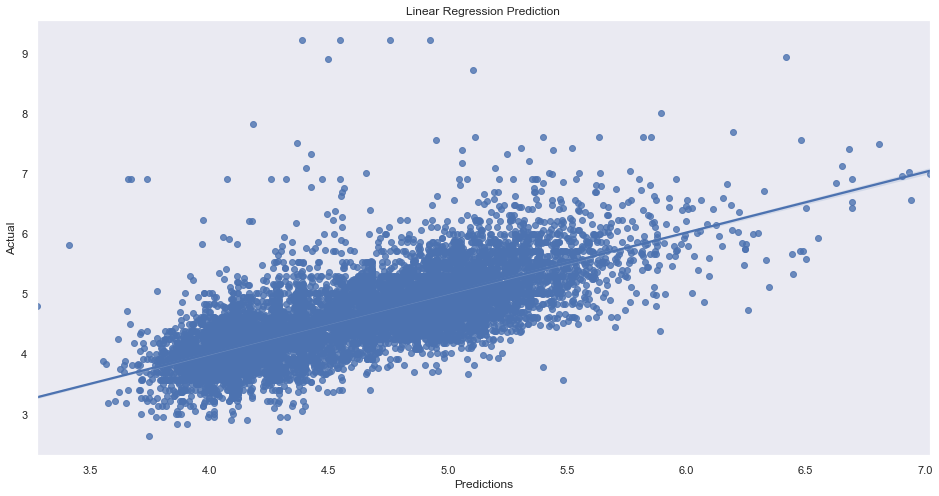

In [578]:
plt.figure(figsize=(16,8))
sns.regplot(lin_reg.predict(X_test),y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Regression Prediction")
plt.grid(False)
plt.show()

In [579]:
linear_model = sm.OLS(y,sm.add_constant(X)).fit()
pred = linear_model.predict(sm.add_constant(X))
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     1828.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:56:55   Log-Likelihood:                -20708.
No. Observations:               31880   AIC:                         4.146e+04
Df Residuals:                   31859   BIC:                         4.163e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

The output above displays the coefficients, test statistics, and p-values for the multiple linear regression. We notice that availability_90, availability_365, and number_of_reviews are not statistically significant (p-value > 0.05). This indicates that these features are not useful in predicting price. THe adjusted R2 is the same as the R2 which indicates that multicollinearity is not cause of concern. (the adjusted R2 peanalizes the model if multicollinearity exists)

### Decision Tree

We also tried implementing a Decision Tree model, but found  a huge difference in the in sample and out of sample R2 values. For this reason, we recommend using a linear regression model to predict price.

In [580]:
'''Decision Tree Regressor'''
DTree = DecisionTreeRegressor(min_samples_leaf=.0001)
DTree.fit(X_train,y_train)

print("In Sample Test Dataset Prediction")
print("-------------------------------------------------------------------------------")

print_evaluate(y_train, DTree.predict(X_train))
print("=======================================================================================================================")

print("Out of Sample Test Dataset Prediction")
print("-------------------------------------------------------------------------------")
print_evaluate(y_test, DTree.predict(X_test))

In Sample Test Dataset Prediction
-------------------------------------------------------------------------------
MAE: 0.2075212615983355
MSE: 0.08685674451512562
RMSE: 0.2947146832363899
R2 Square 0.8116334615519809
Out of Sample Test Dataset Prediction
-------------------------------------------------------------------------------
MAE: 0.403365076995294
MSE: 0.2942659662265109
RMSE: 0.5424628708275903
R2 Square 0.36093832651138413


# Conclusion

We noticied that there is higher competition for Airbnb hosts in Manhattan, and that the most expensive neighborhoods (Flatiron District and Tribeca) are located in downtown Manhattan. Also, there are a large number of entire home/apartment type listings in Manhattan which indicates that hosts in Manhattan might percieve Airbnb listings as a business opportunity, viz-av-z hosts in Brooklyn, who would be looking to save rent/money by renting out private rooms.

COVID-19 impacted the price of listings which reduced after the onset of the pandemic. The nunber of reviews also decreased as a result of the pandemic. 

The number of reviews plays a significant role in determining the prediction of host types, but is not significant in predicting price of listings. However, features related to accommodation, room type and neighborhoods in Manhattan, Queens and Brooklyn play an important role in determining future price of the listings. These features would be crucial for AirBnb to predict revenue.


# Recommendations for Prospective Hosts
* Regular updates of listing images and descriptions as ratings are based on these features
* Adjustment of listing prices based on the availability of competing listings within the neighborhood, especially during special circumstances such as COVID-19 
* We observe a trend of higher listing prices for superhosts, which provides prospective hosts with a great incentive to aim for becoming superhosts
* Airbnb hosts can place more emphasis in finding guests who are opinion leaders and bloggers who can leave positive reviews and increase exposure of the listing 
* Prospective hosts can penetrate markets/boroughs with popular neighborhood locations where listings are in higher demand

# Future Work

* Exploring other models to predict price where overfitting is not an issue
* Finding new alternatives to deal with outliers
* Identifying new ways to deal with missing values 
* Gaining more insight on the lack of number of listings for shared room types in NYC